In [3]:
#!/usr/bin/env sage
"""
Part 1: Polynomial Benchmark Testing Module
Run this once to collect all benchmark data, then save results to file
"""

from sage.all import *
import itertools
import subprocess
import tempfile
import os
import json
import time
import signal
from datetime import datetime
import numpy as np
import pickle

# Matrix multiplication exponent
OMEGA = 2.373  # Using best known bound

# Field definitions
STANDARD_PRIME = 2147483489  # Supports msolve
LARGE_PRIME = 9223372036854775783  # ≈2^63, no msolve support

def fuss_catalan(n, d):
    """Compute the Fuss-Catalan number D = (1/(n(d-1)+1)) * C(nd, n)"""
    if n == 0 or d == 0:
        return 1
    return binomial(n*d, n) / (n*(d-1) + 1)

def compute_f4_fglm_complexity(n, d, omega=OMEGA):
    """Compute theoretical F4+FGLM complexity: O(n * d^(n*omega))"""
    d_reg = n*(d-1) + 1
    return float(binomial(n+d_reg, n)**omega + n * d**(n * omega))

def compute_dixon_complexity(n, d, omega=OMEGA):
    """Compute theoretical Dixon complexity: O(nd * D^omega) where D is Fuss-Catalan"""
    D = float(fuss_catalan(n, d))
    return float(n * d * D**omega)

def compute_resultant_complexity(n, d, omega=OMEGA):
    """Compute theoretical resultant complexity using Sylvester matrix determinant"""
    if n != 2:
        return float('inf')
    # Sylvester matrix is d×d, determinant computation is O(d^omega)
    return float(d**omega)

def compute_complexity_ratio(n, d, omega=OMEGA):
    """Compute the ratio of Dixon to F4+FGLM complexity"""
    dixon = compute_dixon_complexity(n, d, omega)
    f4 = compute_f4_fglm_complexity(n, d, omega)
    if dixon > 0:
        return f4 / dixon
    return 1.0

def format_complexity(comp):
    """Format complexity value as power of 2"""
    if comp <= 0:
        return "0"
    import math
    exponent = math.log2(comp)
    return f"2^{exponent:.1f}"

def create_extension_field():
    """Create GF(2^128) extension field"""
    F2 = GF(2)
    R = PolynomialRing(F2, 'x')
    x = R.gen()
    irreducible = x^128 + x^7 + x^2 + x + 1
    return GF(2^128, name='t', modulus=irreducible)

def random_polynomial_system(n, k, field, m, r):
    """Generate random polynomial system with LEX ordering"""
    R = PolynomialRing(field, n, 'x', order='lex')
    x = R.gens()
    ps = []
    
    all_exponents = list(itertools.product(range(k + 1), repeat=n))
    valid_exponents = [exp for exp in all_exponents if sum(exp) <= k]
    
    r0 = min(r, binomial(n+k, k)) if r > 0 else binomial(n+k, k)
    
    for i in range(m):
        poly = 0
        used_indices = set()
        while len(used_indices) < min(r0, len(valid_exponents)):
            idx = randint(0, len(valid_exponents) - 1)
            if idx not in used_indices:
                exponents = valid_exponents[idx]
                coefficient = field.random_element()
                if coefficient != 0:
                    term = coefficient * prod([x[j] ** exponents[j] for j in range(n)])
                    poly += term
                    used_indices.add(idx)
        ps.append(poly)
    
    return ps, R

def cleanup_all_processes():
    """Cleanup to avoid process conflicts"""
    try:
        os.system("pkill -9 -f magma 2>/dev/null")
        os.system("pkill -9 -f Magma 2>/dev/null")
        os.system("rm -f /tmp/magma_* 2>/dev/null")
        os.system("rm -f /tmp/sage_magma_* 2>/dev/null")
        os.system("rm -f /tmp/interface* 2>/dev/null")
        
        import gc
        gc.collect()
        time.sleep(0.5)
    except:
        pass

def benchmark_magma_subprocess(polys, ring, timeout=120):
    """Benchmark Magma using subprocess (F4+FGLM)"""
    try:
        field = ring.base_ring()
        nvars = ring.ngens()
        var_names = ','.join(ring.variable_names())
        
        script_lines = []
        
        if hasattr(field, 'characteristic') and hasattr(field, 'degree'):
            char = field.characteristic()
            deg = field.degree()
            if deg == 1:
                script_lines.append(f"F := GF({char});")
            else:
                script_lines.append(f"F<t> := GF({char}, {deg});")
        else:
            script_lines.append(f"F<t> := GF({field});")
        
        script_lines.extend([
            f"R<{var_names}> := PolynomialRing(F, {nvars}, \"lex\");",
            "polys := [",
        ])
        
        for i, poly in enumerate(polys):
            poly_str = str(poly)
            if i < len(polys) - 1:
                script_lines.append(f"    {poly_str},")
            else:
                script_lines.append(f"    {poly_str}")
        
        script_lines.extend([
            "];",
            "I := ideal<R | polys>;",
            "gb := GroebnerBasis(I);",
            "printf \"%o\\n\", #gb;",
            "quit;"
        ])
        
        with tempfile.NamedTemporaryFile(mode='w', suffix='.m', delete=False) as f:
            f.write('\n'.join(script_lines))
            script_file = f.name
        
        start_time = time.time()
        result = subprocess.run(
            ["magma", script_file],
            capture_output=True,
            text=True,
            timeout=timeout
        )
        elapsed = time.time() - start_time
        
        os.remove(script_file)
        
        if result.returncode == 0:
            return elapsed
        else:
            return None
            
    except subprocess.TimeoutExpired:
        try:
            os.remove(script_file)
        except:
            pass
        return f">{timeout}"
    except Exception:
        return None

def benchmark_magma_resultant(polys, ring, timeout=120):
    """Benchmark Magma using Resultant method (only for 2 equations)"""
    if len(polys) != 2:
        return None
        
    try:
        field = ring.base_ring()
        nvars = ring.ngens()
        var_names = ring.variable_names()
        vars_str = ','.join(var_names)
        
        script_lines = []
        
        if hasattr(field, 'characteristic') and hasattr(field, 'degree'):
            char = field.characteristic()
            deg = field.degree()
            if deg == 1:
                script_lines.append(f"F := GF({char});")
            else:
                script_lines.append(f"F<t> := GF({char}, {deg});")
        else:
            script_lines.append(f"F<t> := GF({field});")
        
        script_lines.extend([
            f"R<{vars_str}> := PolynomialRing(F, {nvars}, \"lex\");",
            f"f := {str(polys[0])};",
            f"g := {str(polys[1])};",
            "",
            "// Compute resultant with respect to last variable",
        ])
        
        if nvars == 2:
            script_lines.extend([
                f"res := Resultant(f, g, {var_names[-1]});",
                "// Solve univariate polynomial",
                "if res ne 0 then",
                "    UP := PolynomialRing(F);",
                "    res_uni := UP!res;",
                "    roots := Roots(res_uni);",
                "    printf \"Found %o roots\\n\", #roots;",
                "else",
                "    printf \"Resultant is zero\\n\";",
                "end if;",
            ])
        else:
            script_lines.extend([
                f"// Eliminate {var_names[-1]} first",
                f"res1 := Resultant(f, g, {var_names[-1]});",
                "if res1 ne 0 then",
                "    printf \"Resultant computed\\n\";",
                "else",
                "    printf \"Resultant is zero\\n\";",
                "end if;",
            ])
        
        script_lines.append("quit;")
        
        with tempfile.NamedTemporaryFile(mode='w', suffix='.m', delete=False) as f:
            f.write('\n'.join(script_lines))
            script_file = f.name
        
        start_time = time.time()
        result = subprocess.run(
            ["magma", script_file],
            capture_output=True,
            text=True,
            timeout=timeout
        )
        elapsed = time.time() - start_time
        
        os.remove(script_file)
        
        if result.returncode == 0:
            return elapsed
        else:
            return None
            
    except subprocess.TimeoutExpired:
        try:
            os.remove(script_file)
        except:
            pass
        return f">{timeout}"
    except Exception:
        return None

def benchmark_dixon(polys, ring, field_char, m, timeout=120):
    """Benchmark Dixon method"""
    if m <= 1:
        return None
        
    if not os.path.exists("./dixon"):
        return None
        
    try:
        with tempfile.NamedTemporaryFile(mode='w', suffix='.dat', delete=False) as f:
            f.write(f"{field_char}\n")
            poly_strs = [str(poly) for poly in polys]
            f.write(", ".join(poly_strs) + "\n")
            eliminate_vars = [f'x{i}' for i in range(m-1)]
            f.write(", ".join(eliminate_vars) + "\n")
            input_file = f.name
        
        start = time.time()
        result = subprocess.run(
            ["./dixon", "--silent", input_file],
            capture_output=True,
            text=True,
            timeout=timeout
        )
        elapsed = time.time() - start
        
        os.remove(input_file)
        
        if result.returncode == 0:
            return elapsed
        else:
            return None
            
    except subprocess.TimeoutExpired:
        try:
            os.remove(input_file)
        except:
            pass
        return f">{timeout}"
    except Exception:
        return None

def benchmark_msolve(polys, ring, p, n, m, timeout=120):
    """Benchmark msolve elimination (only for supported fields)"""
    if n <= 1 or p > (2**31 - 1):
        return None
        
    try:
        with tempfile.NamedTemporaryFile(mode='w', suffix='.ms', delete=False) as f:
            var_names = [f"x{i}" for i in range(n)]
            f.write(", ".join(var_names) + "\n")
            f.write(f"{p}\n")
            
            for i, poly in enumerate(polys):
                poly_str = str(poly)
                if i < len(polys) - 1:
                    f.write(poly_str + ",\n")
                else:
                    f.write(poly_str + "\n")
            input_file = f.name
        
        eliminate_count = min(n-1, m-1) if m > 1 else n-1
        
        start = time.time()
        result = subprocess.run(
            ["msolve", "-e", str(eliminate_count), "-g", "2", "-f", input_file],
            capture_output=True,
            text=True,
            timeout=timeout
        )
        elapsed = time.time() - start
        
        os.remove(input_file)
        
        if result.returncode == 0:
            return elapsed
        else:
            return None
            
    except subprocess.TimeoutExpired:
        try:
            os.remove(input_file)
        except:
            pass
        return f">{timeout}"
    except Exception:
        return None

def run_single_benchmark(n, d, field, m, r, timeout=120, include_resultant=False, include_msolve=False):
    """Run a single benchmark test"""
    set_random_seed(42 + n + d + m)
    polys, ring = random_polynomial_system(n, d, field, m, r)
    
    results = {}
    
    # Get field characteristic
    if hasattr(field, 'characteristic'):
        field_char = field.characteristic()
    else:
        field_char = field
    
    # Compute theoretical complexities
    complexities = {
        'f4_fglm': compute_f4_fglm_complexity(n, d, OMEGA),
        'dixon': compute_dixon_complexity(n, d, OMEGA),
        'resultant': compute_resultant_complexity(m, d, OMEGA) if m == 2 else float('inf'),
        'dixon_f4_ratio': compute_complexity_ratio(n, d, OMEGA)
    }
    
    # Benchmark each method
    results['magma'] = benchmark_magma_subprocess(polys, ring, timeout)
    results['dixon'] = benchmark_dixon(polys, ring, field_char, m, timeout)
    
    if include_msolve:
        results['msolve'] = benchmark_msolve(polys, ring, field_char, n, m, timeout)
    else:
        results['msolve'] = None
    
    if include_resultant and m == 2:
        results['magma_resultant'] = benchmark_magma_resultant(polys, ring, timeout)
    else:
        results['magma_resultant'] = None
    
    # Calculate empirical time ratios
    if results['magma'] and results['dixon'] and not isinstance(results['magma'], str) and not isinstance(results['dixon'], str):
        results['dixon_magma_time_ratio'] = results['magma'] / results['dixon']
    else:
        results['dixon_magma_time_ratio'] = None
    
    return results, complexities

def format_time_result(result):
    """Format timing result for display"""
    if result is None:
        return "FAIL"
    elif isinstance(result, str) and result.startswith(">"):
        return result + "s"
    else:
        return f"{result:.4f}s"

def run_all_benchmarks():
    """Run complete benchmark suite and save results"""
    import time
    start_time = time.time()
    
    print("="*100)
    print("POLYNOMIAL SOLVER BENCHMARK - DATA COLLECTION")
    print("="*100)
    print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*100)
    
    # Define fields
    standard_field = GF(STANDARD_PRIME)
    large_prime_field = GF(LARGE_PRIME)
    extension_field = create_extension_field()
    
    fields = {
        'standard': standard_field,
        'large_prime': large_prime_field,
        'extension': extension_field
    }
    
    field_names = {
        'standard': f'GF({STANDARD_PRIME})',
        'large_prime': f'GF({LARGE_PRIME})',
        'extension': 'GF(2^128)'
    }
    
    all_results = {}
    
    for field_key, field in fields.items():
        print(f"\n{'='*80}")
        print(f"TESTING ON {field_names[field_key]}")
        print("="*80)
        
        include_msolve = (field_key == 'standard')
        field_results = {}
        
        # TEST SUITE 1: Fixed degree 2, varying variables
        print("\n" + "="*70)
        print("TEST SUITE 1: Fixed Degree 2, Varying Variables")
        print("="*70)
        print(f"{'n':<5} {'Magma':<12} {'Dixon':<12} {'msolve':<12} {'Resultant':<12} {'M/D Ratio':<12} {'F4 Complex':<15} {'Dixon Complex':<15} {'Theory Ratio':<12}")
        print("-" * 130)
        
        test1_data = []
        for n in range(2, 11):
            m = n
            r = min(300, binomial(n+2, 2))
            timeout = min(300, 30*n + 30)
            
            results, complexities = run_single_benchmark(
                n, 2, field, m, r, timeout,
                include_resultant=(n==2),
                include_msolve=include_msolve
            )
            
            test1_data.append({
                'n': n, 'd': 2, 'm': m,
                'results': results,
                'complexities': complexities
            })
            
            # Format output
            magma_str = format_time_result(results.get('magma'))
            dixon_str = format_time_result(results.get('dixon'))
            msolve_str = format_time_result(results.get('msolve')) if include_msolve else "N/A"
            resultant_str = format_time_result(results.get('magma_resultant')) if n == 2 else "N/A"
            
            # Calculate empirical ratio
            ratio_str = "N/A"
            if results.get('dixon_magma_time_ratio') is not None:
                ratio_str = f"{results['dixon_magma_time_ratio']:.4f}"
            
            print(f"{n:<5} {magma_str:<12} {dixon_str:<12} {msolve_str:<12} {resultant_str:<12} {ratio_str:<12} "
                  f"{format_complexity(complexities['f4_fglm']):<15} {format_complexity(complexities['dixon']):<15} "
                  f"{complexities['dixon_f4_ratio']:.6f}")
        
        field_results['fixed_degree_2'] = test1_data
        
        # TEST SUITE 2: Fixed degree 3, varying variables
        print("\n" + "="*70)
        print("TEST SUITE 2: Fixed Degree 3, Varying Variables")
        print("="*70)
        print(f"{'n':<5} {'Magma':<12} {'Dixon':<12} {'msolve':<12} {'M/D Ratio':<12} {'F4 Complex':<15} {'Dixon Complex':<15} {'Theory Ratio':<12}")
        print("-" * 115)
        
        test2_data = []
        for n in range(2, 8):
            m = n
            r = min(300, binomial(n+3, 3))
            timeout = min(300, 60 * n)
            
            results, complexities = run_single_benchmark(
                n, 3, field, m, r, timeout,
                include_resultant=(n==2),
                include_msolve=include_msolve
            )
            
            test2_data.append({
                'n': n, 'd': 3, 'm': m,
                'results': results,
                'complexities': complexities
            })
            
            # Format output
            magma_str = format_time_result(results.get('magma'))
            dixon_str = format_time_result(results.get('dixon'))
            msolve_str = format_time_result(results.get('msolve')) if include_msolve else "N/A"
            
            # Calculate empirical ratio
            ratio_str = "N/A"
            if results.get('dixon_magma_time_ratio') is not None:
                ratio_str = f"{results['dixon_magma_time_ratio']:.4f}"
            
            print(f"{n:<5} {magma_str:<12} {dixon_str:<12} {msolve_str:<12} {ratio_str:<12} "
                  f"{format_complexity(complexities['f4_fglm']):<15} {format_complexity(complexities['dixon']):<15} "
                  f"{complexities['dixon_f4_ratio']:.6f}")
        
        field_results['fixed_degree_3'] = test2_data
        
        # TEST SUITE 3: 2 equations, 3 variables, varying degree
        print("\n" + "="*70)
        print("TEST SUITE 3: 2 Equations, 3 Variables, Varying Degree (Underdetermined)")
        print("="*70)
        print(f"{'d':<5} {'Magma':<12} {'Dixon':<12} {'msolve':<12} {'Resultant':<12} {'M/D Ratio':<12} {'F4 Complex':<15} {'Dixon Complex':<15} {'Theory Ratio':<12}")
        print("-" * 130)
        
        test3_data = []
        for d in range(2, 11):
            n, m = 3, 2
            r = min(300, binomial(n+d, d))
            timeout = min(300, 30 * d)
            
            results, complexities = run_single_benchmark(
                n, d, field, m, r, timeout,
                include_resultant=True,
                include_msolve=include_msolve
            )
            
            test3_data.append({
                'n': n, 'd': d, 'm': m,
                'results': results,
                'complexities': complexities
            })
            
            # Format output
            magma_str = format_time_result(results.get('magma'))
            dixon_str = format_time_result(results.get('dixon'))
            msolve_str = format_time_result(results.get('msolve')) if include_msolve else "N/A"
            resultant_str = format_time_result(results.get('magma_resultant'))
            
            # Calculate empirical ratio
            ratio_str = "N/A"
            if results.get('dixon_magma_time_ratio') is not None:
                ratio_str = f"{results['dixon_magma_time_ratio']:.4f}"
            
            print(f"{d:<5} {magma_str:<12} {dixon_str:<12} {msolve_str:<12} {resultant_str:<12} {ratio_str:<12} "
                  f"{format_complexity(complexities['f4_fglm']):<15} {format_complexity(complexities['dixon']):<15} "
                  f"{complexities['dixon_f4_ratio']:.6f}")
        
        field_results['underdetermined_2_3'] = test3_data
        
        # TEST SUITE 4: 3 equations, 4 variables, varying degree
        print("\n" + "="*70)
        print("TEST SUITE 4: 3 Equations, 4 Variables, Varying Degree (Underdetermined)")
        print("="*70)
        print(f"{'d':<5} {'Magma':<12} {'Dixon':<12} {'msolve':<12} {'M/D Ratio':<12} {'F4 Complex':<15} {'Dixon Complex':<15} {'Theory Ratio':<12}")
        print("-" * 115)
        
        test4_data = []
        for d in range(2, 7):
            n, m = 4, 3
            r = min(300, binomial(n+d, d))
            timeout = min(300, 60 * d)
            
            results, complexities = run_single_benchmark(
                n, d, field, m, r, timeout,
                include_resultant=False,
                include_msolve=include_msolve
            )
            
            test4_data.append({
                'n': n, 'd': d, 'm': m,
                'results': results,
                'complexities': complexities
            })
            
            # Format output
            magma_str = format_time_result(results.get('magma'))
            dixon_str = format_time_result(results.get('dixon'))
            msolve_str = format_time_result(results.get('msolve')) if include_msolve else "N/A"
            
            # Calculate empirical ratio
            ratio_str = "N/A"
            if results.get('dixon_magma_time_ratio') is not None:
                ratio_str = f"{results['dixon_magma_time_ratio']:.4f}"
            
            print(f"{d:<5} {magma_str:<12} {dixon_str:<12} {msolve_str:<12} {ratio_str:<12} "
                  f"{format_complexity(complexities['f4_fglm']):<15} {format_complexity(complexities['dixon']):<15} "
                  f"{complexities['dixon_f4_ratio']:.6f}")
        
        field_results['underdetermined_3_4'] = test4_data
        
        # TEST SUITE 5: Fixed variables, varying degree
        print("\n" + "="*70)
        print("TEST SUITE 5: Fixed Variables, Varying Degree (Square Systems)")
        print("="*70)
        
        for n in [2, 3, 4, 5, 6, 7, 8]:
            print(f"\n--- Testing with n={n} variables (square system m=n={n}) ---")
            print(f"{'d':<5} {'Magma':<12} {'Dixon':<12} {'msolve':<12} {'Resultant':<12} {'M/D Ratio':<12} {'F4 Complex':<15} {'Dixon Complex':<15} {'Theory Ratio':<12}")
            print("-" * 130)
            
            if n == 2:
                d_range = range(2, 50)
            elif n == 3:
                d_range = range(2, 15)
            elif n == 4:
                d_range = range(2, 8)
            elif n == 5:
                d_range = range(2, 6)
            elif n == 6:
                d_range = range(2, 5)
            else:  # n == 7,8
                d_range = range(2, 4)
            
            test5_data = []
            for d in d_range:
                m = n
                r = min(300, binomial(n+d, d))
                timeout = min(300, 30 * d * n)
                
                results, complexities = run_single_benchmark(
                    n, d, field, m, r, timeout,
                    include_resultant=(n==2),
                    include_msolve=include_msolve
                )
                
                test5_data.append({
                    'n': n, 'd': d, 'm': m,
                    'results': results,
                    'complexities': complexities
                })
                
                # Format output
                magma_str = format_time_result(results.get('magma'))
                dixon_str = format_time_result(results.get('dixon'))
                msolve_str = format_time_result(results.get('msolve')) if include_msolve else "N/A"
                resultant_str = format_time_result(results.get('magma_resultant')) if n == 2 else "N/A"
                
                # Calculate empirical ratio
                ratio_str = "N/A"
                if results.get('dixon_magma_time_ratio') is not None:
                    ratio_str = f"{results['dixon_magma_time_ratio']:.4f}"
                
                print(f"{d:<5} {magma_str:<12} {dixon_str:<12} {msolve_str:<12} {resultant_str:<12} {ratio_str:<12} "
                      f"{format_complexity(complexities['f4_fglm']):<15} {format_complexity(complexities['dixon']):<15} "
                      f"{complexities['dixon_f4_ratio']:.6f}")
            
            field_results[f'fixed_vars_{n}'] = test5_data
        
        all_results[field_key] = field_results
    
    # Save results
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save as pickle for Python analysis
    pickle_file = f'benchmark_results_{timestamp}.pkl'
    with open(pickle_file, 'wb') as f:
        pickle.dump({
            'results': all_results,
            'field_names': field_names,
            'timestamp': timestamp,
            'omega': OMEGA
        }, f)
    print(f"\n✓ Results saved to {pickle_file}")
    
    # Also save as JSON for portability
    json_file = f'benchmark_results_{timestamp}.json'
    
    def convert_for_json(obj):
        """Convert non-JSON-serializable objects"""
        if isinstance(obj, (np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.int32, np.int64)):
            return int(obj)
        elif hasattr(obj, 'parent'):  # Sage types
            return float(obj)
        return obj
    
    # Deep convert all values
    def deep_convert(obj):
        if isinstance(obj, dict):
            return {k: deep_convert(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [deep_convert(v) for v in obj]
        else:
            return convert_for_json(obj)
    
    with open(json_file, 'w') as f:
        json.dump(deep_convert({
            'results': all_results,
            'field_names': field_names,
            'timestamp': timestamp,
            'omega': OMEGA
        }), f, indent=2)
    print(f"✓ Results also saved as JSON to {json_file}")
    
    print("\n" + "="*100)
    print("DATA COLLECTION COMPLETE")
    print("="*100)
    
    # Calculate and display total time
    end_time = time.time()
    total_time = end_time - start_time
    hours = int(total_time // 3600)
    minutes = int((total_time % 3600) // 60)
    seconds = total_time % 60
    
    print(f"End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Total Time: {hours}h {minutes}m {seconds:.1f}s")
    print("="*100)
    
    return all_results, field_names, timestamp

if __name__ == "__main__":
    # Run benchmarks and save results
    results, names, timestamp = run_all_benchmarks()
    print(f"\nBenchmark completed at {timestamp}")
    print("Use the visualization module to analyze results.")

POLYNOMIAL SOLVER BENCHMARK - DATA COLLECTION
Start Time: 2025-09-03 18:00:44

TESTING ON GF(2147483489)

TEST SUITE 1: Fixed Degree 2, Varying Variables
n     Magma        Dixon        msolve       Resultant    M/D Ratio    F4 Complex      Dixon Complex   Theory Ratio
----------------------------------------------------------------------------------------------------------------------------------
2     0.0627s      0.0315s      0.0649s      0.0244s      1.9894       2^8.2           2^4.4           13.981977
3     0.0446s      0.0988s      0.1931s      N/A          0.4517       2^12.3          2^8.1           18.401149
4     0.0340s      0.0925s      0.1054s      N/A          0.3680       2^16.6          2^12.0          23.665220
5     0.0695s      0.1038s      0.0848s      N/A          0.6692       2^21.0          2^16.1          29.857696
6     0.1158s      0.3539s      0.2513s      N/A          0.3272       2^25.5          2^20.3          36.750896
7     0.2425s      1.6872s      0.

Loading benchmark results...
Loading from benchmark_results_20250904_044359.pkl
Creating visualizations...
  Figure 1: Fixed Degree Analysis...
  Figure 2: Fixed Variables Analysis...
  Figure 3: Underdetermined Systems...
  Figure 4: Complexity Heatmaps...
  Figure 5: Performance Summary...

✓ All figures saved with timestamp 20250904_044359 (Base-2 scales, 1s = 2^22 ops)


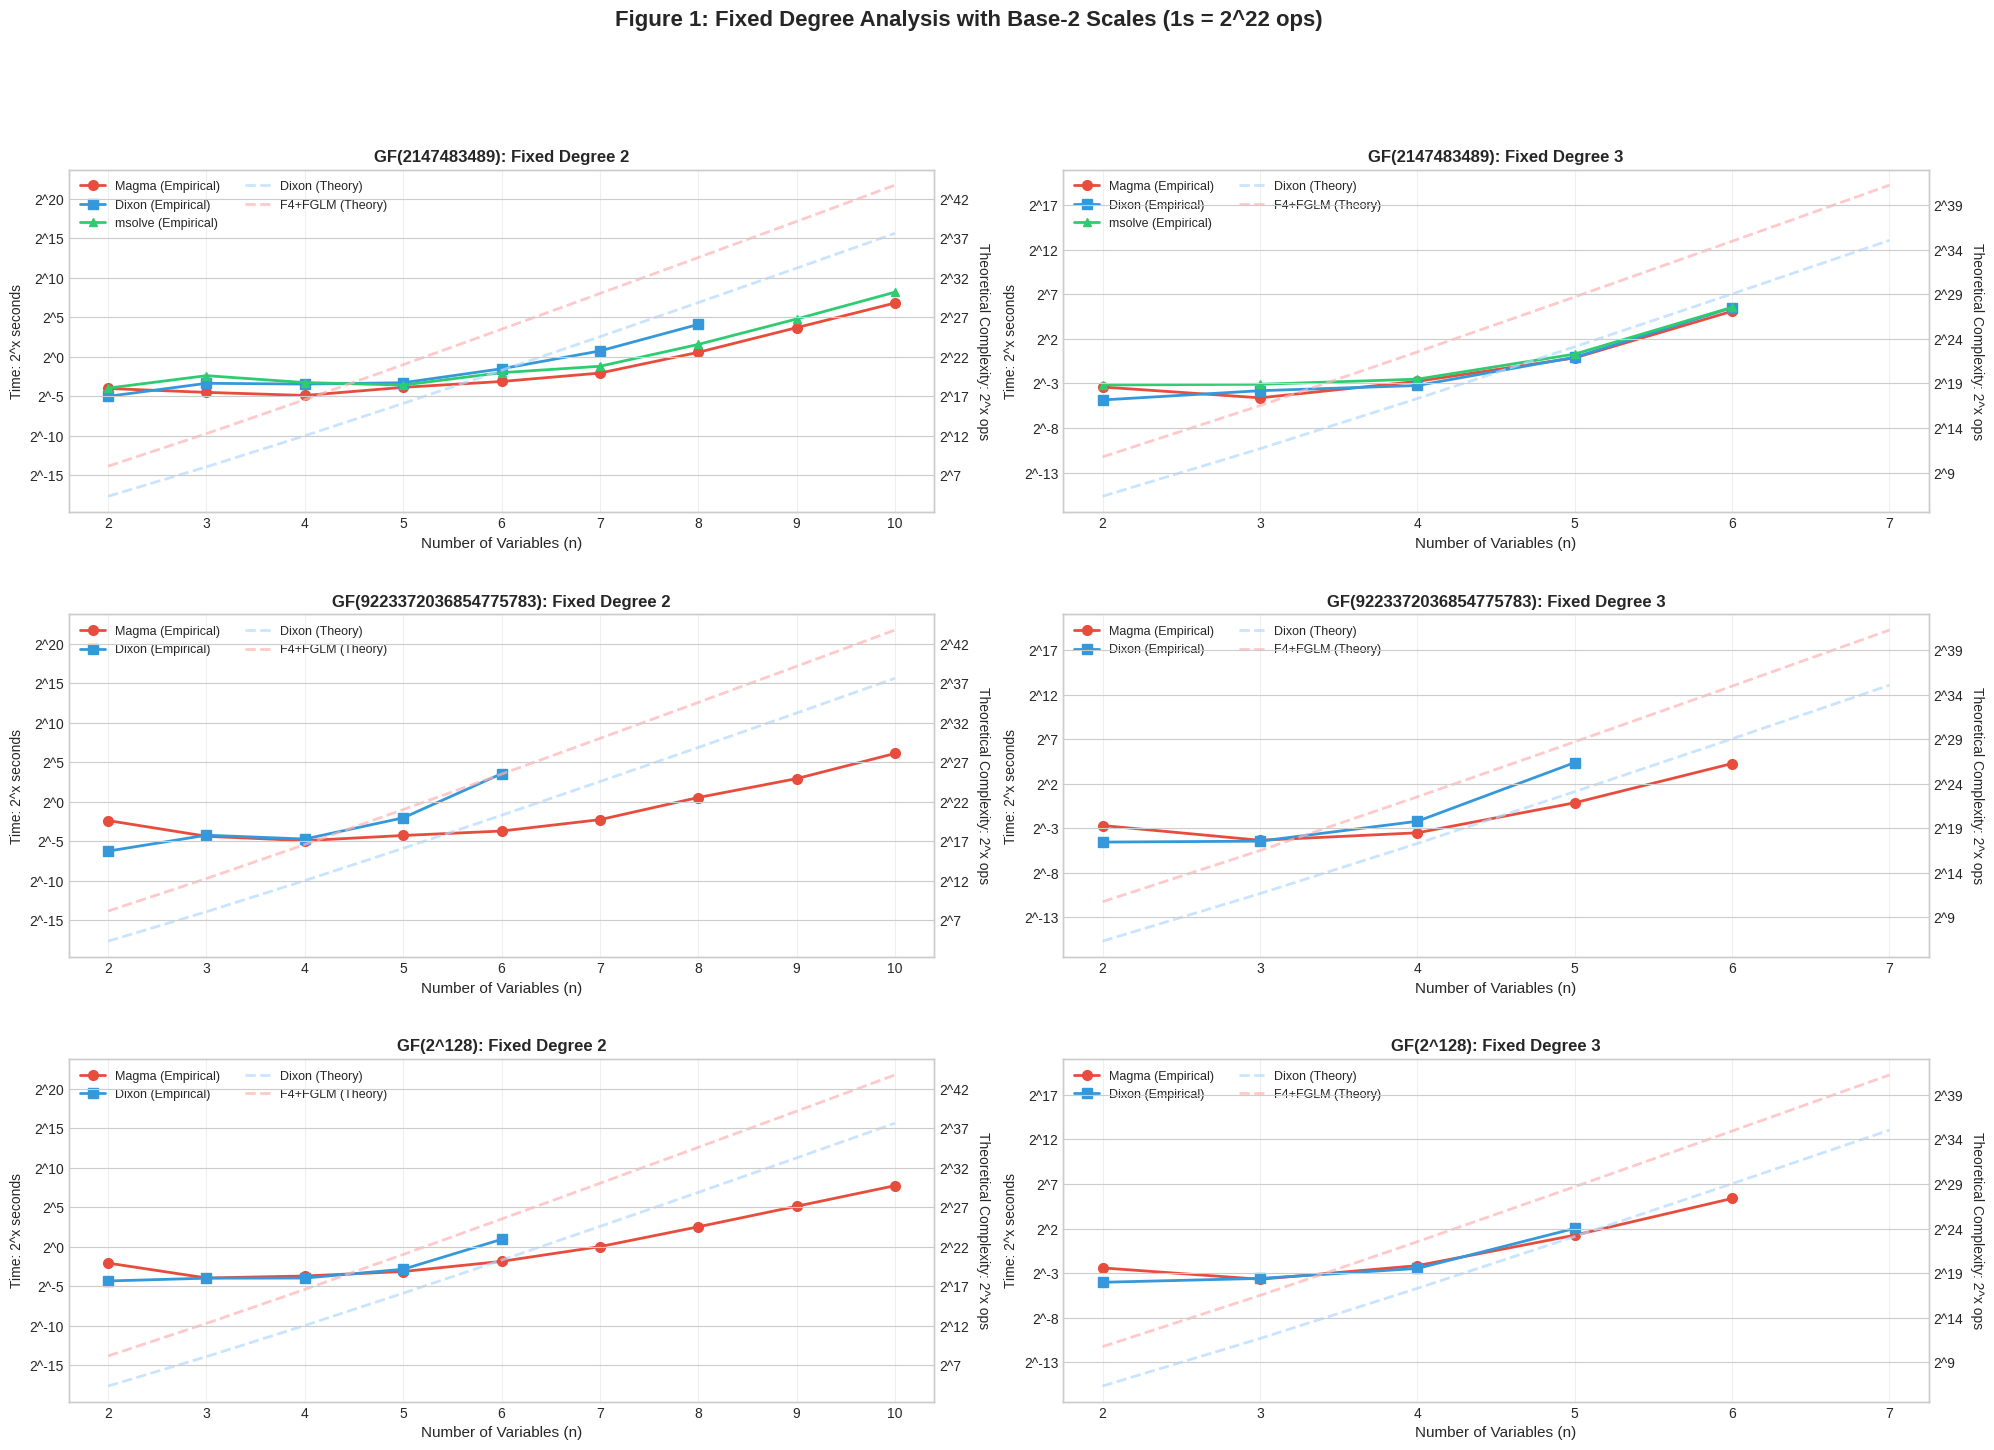

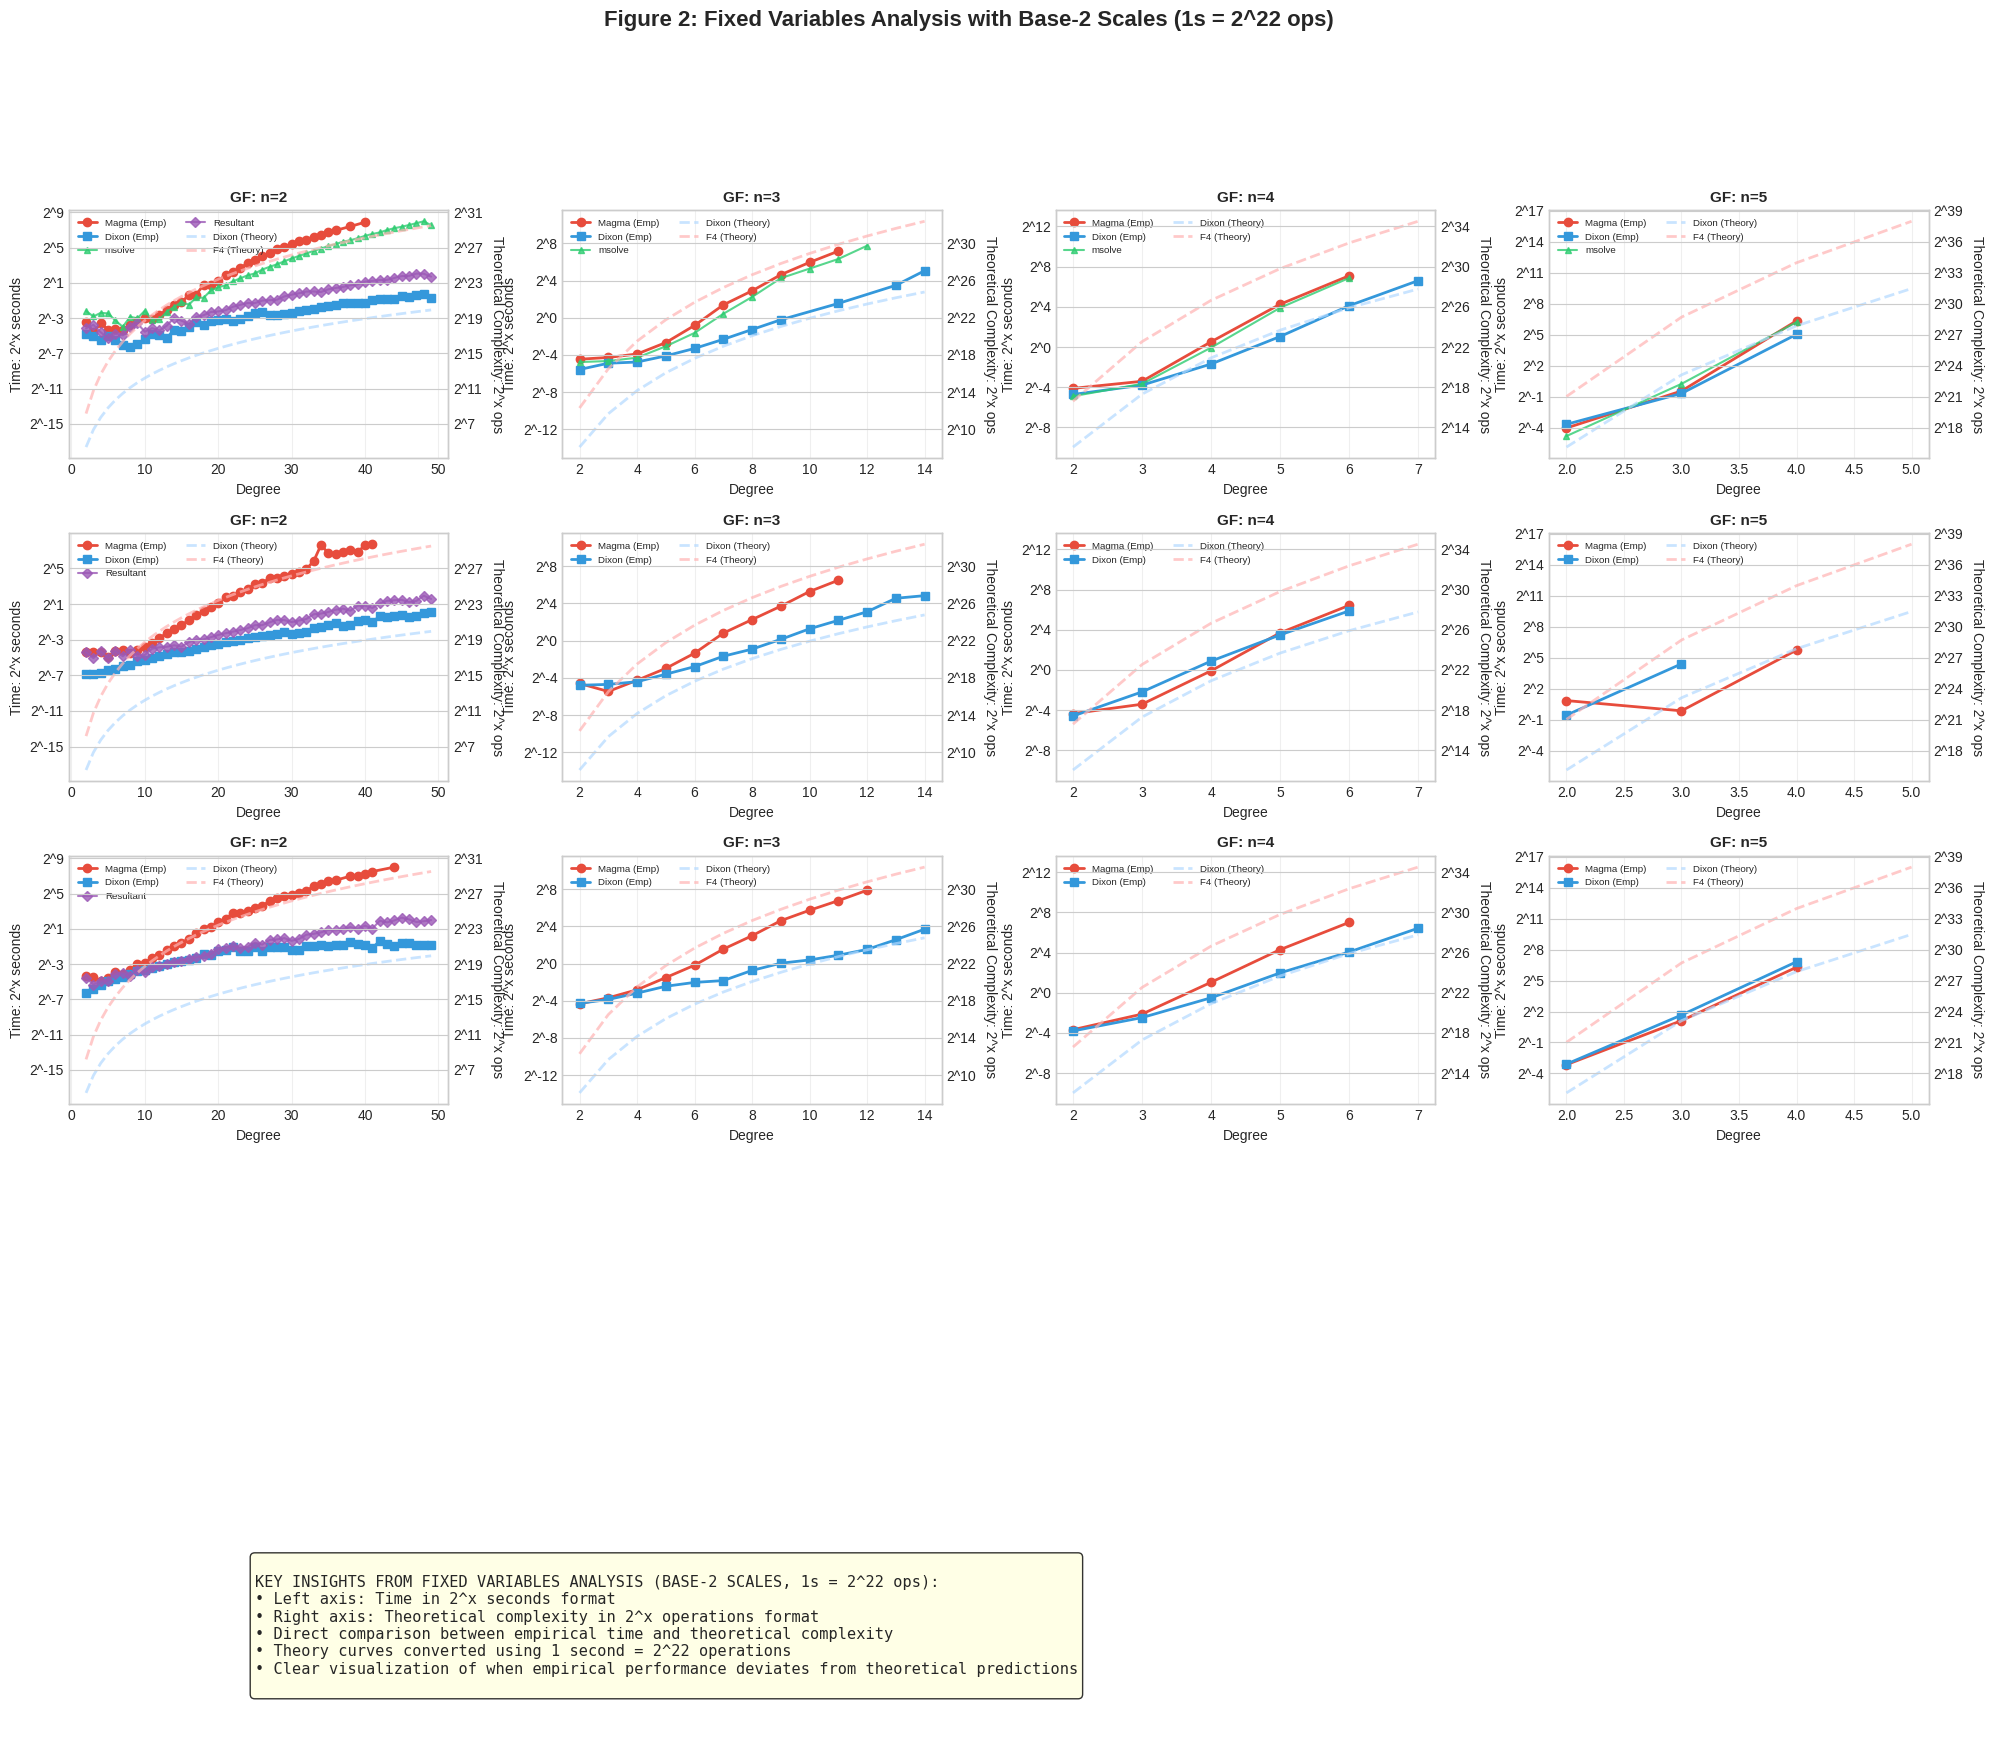

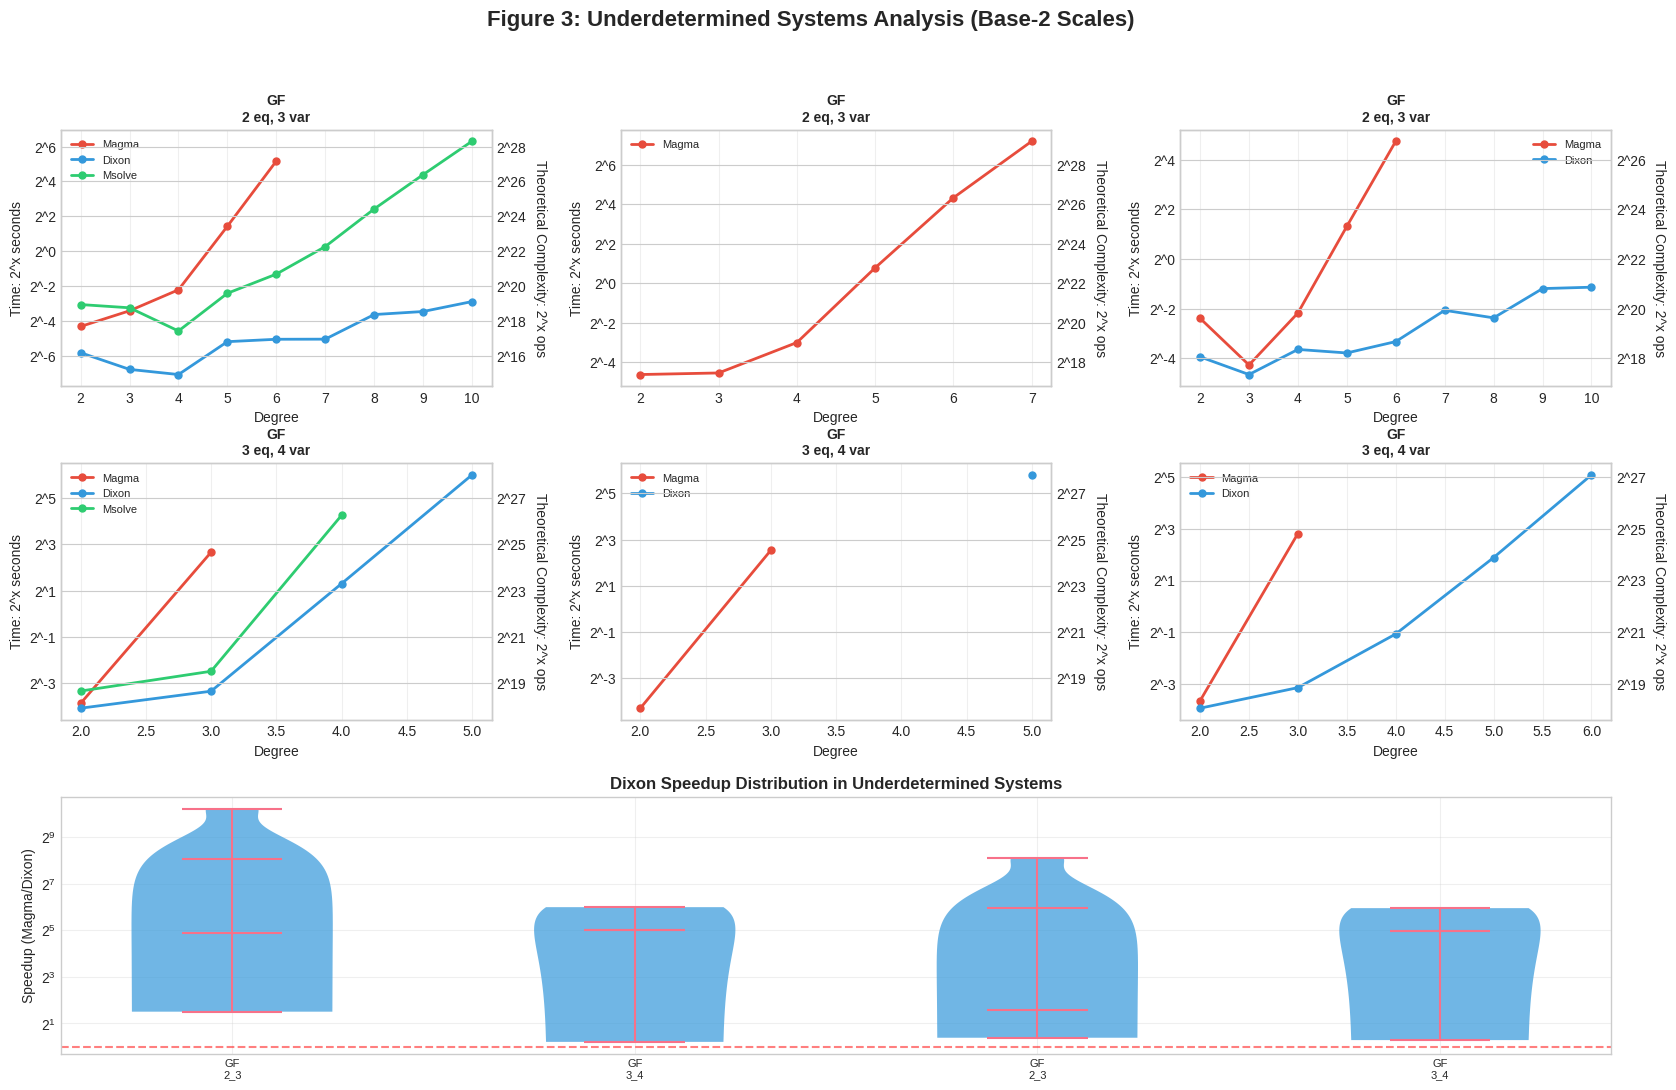

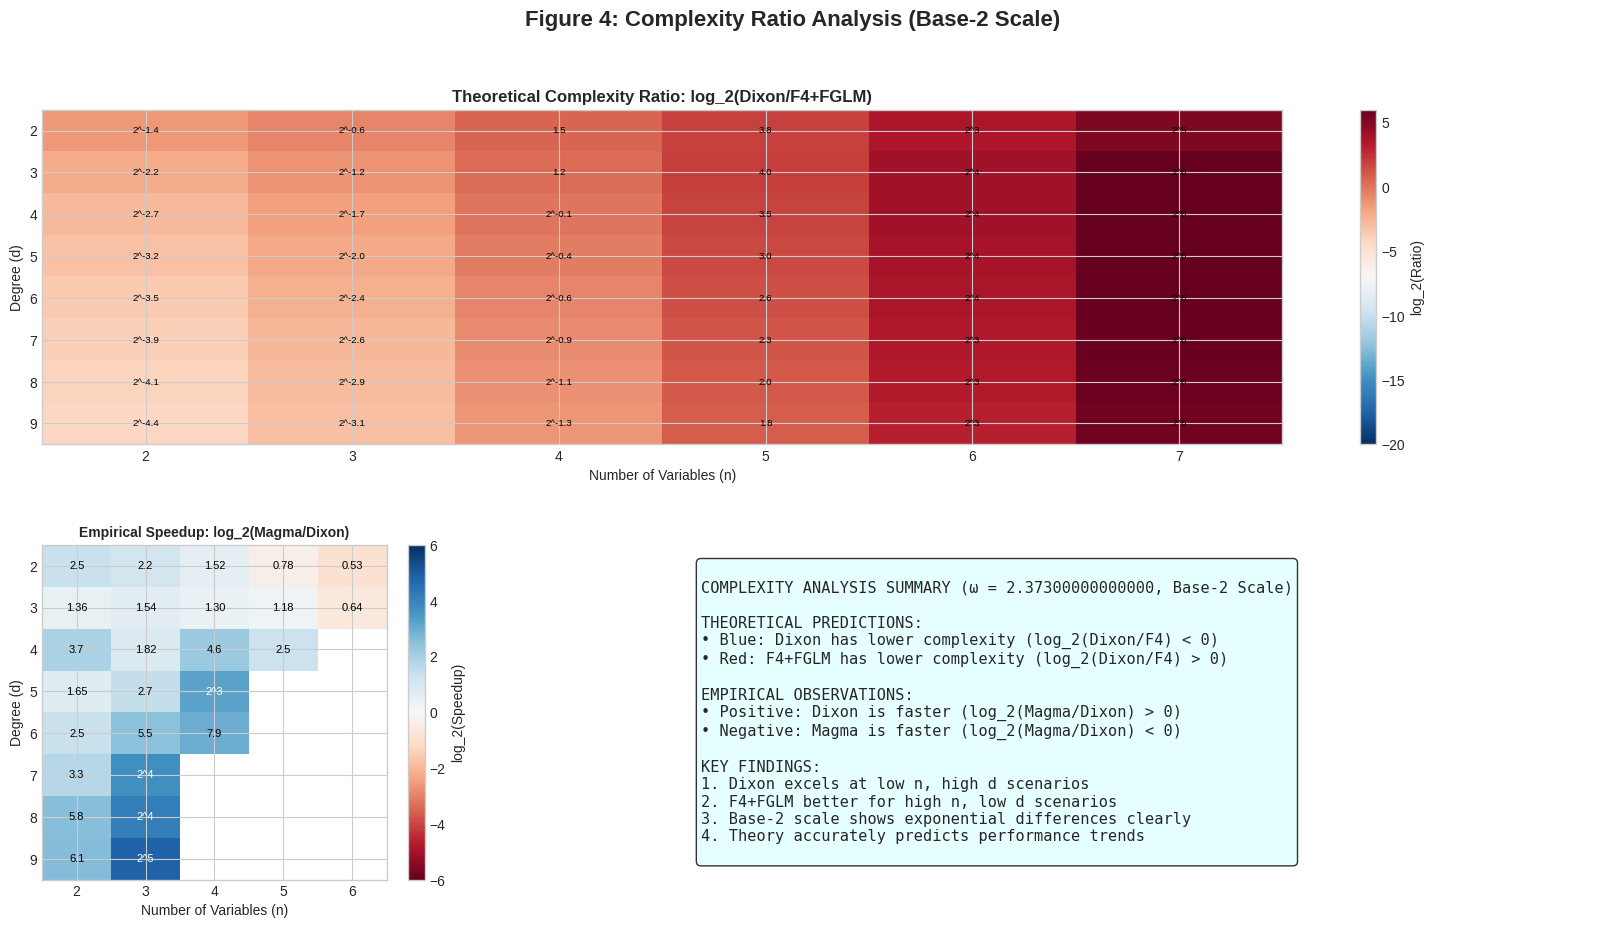

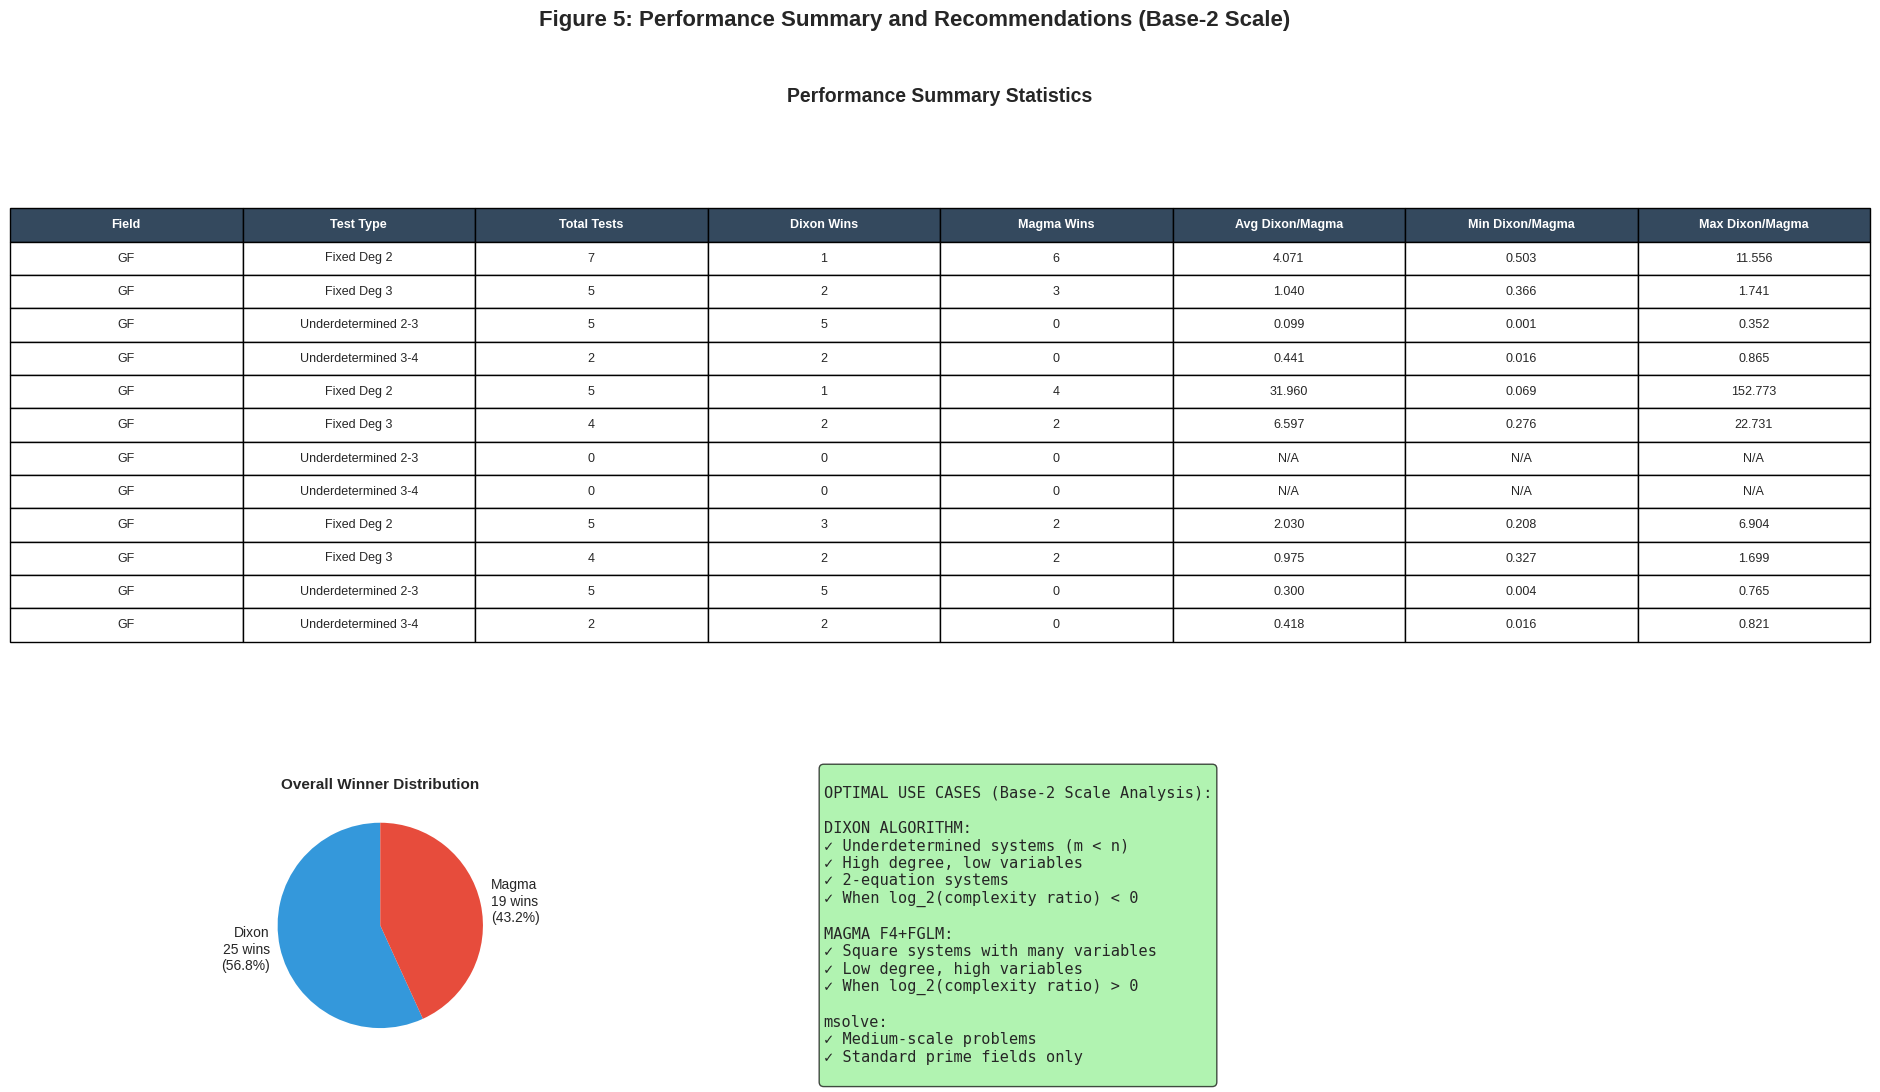


Visualization complete!


In [1]:
#!/usr/bin/env python3
"""
Complete Polynomial Benchmark Visualization Module - Base-2 logarithmic scales with 1s=2^22 operations
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import pickle
import json
from datetime import datetime
import math

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Fixed conversion: 1 second = 2^22 operations
TIME_TO_OPS_FACTOR = 22  # log2 of operations per second

def load_results(filename=None):
    """Load benchmark results from file"""
    if filename is None:
        import glob
        import os
        
        pkl_files = glob.glob('benchmark_results_*.pkl')
        json_files = glob.glob('benchmark_results_*.json')
        
        if pkl_files:
            filename = max(pkl_files, key=os.path.getctime)
            print(f"Loading from {filename}")
            with open(filename, 'rb') as f:
                data = pickle.load(f)
        elif json_files:
            filename = max(json_files, key=os.path.getctime)
            print(f"Loading from {filename}")
            with open(filename, 'r') as f:
                data = json.load(f)
        else:
            raise FileNotFoundError("No benchmark results found. Run testing module first.")
    else:
        if filename.endswith('.pkl'):
            with open(filename, 'rb') as f:
                data = pickle.load(f)
        else:
            with open(filename, 'r') as f:
                data = json.load(f)
    
    return data['results'], data['field_names'], data.get('timestamp', ''), data.get('omega', 2.373)

def get_numeric_time(result):
    """Convert time result to numeric value"""
    if result is None:
        return np.nan
    elif isinstance(result, str) and result.startswith(">"):
        return np.nan
        
    else:
        try:
            return float(result)
        except:
            return np.nan

def format_log2_time(value):
    """Format time value as 2^x seconds"""
    if value <= 0 or np.isnan(value) or np.isinf(value):
        return "0"
    exponent = math.log2(value)
    return f"2^{exponent:.1f}s"

def format_log2_complexity(value):
    """Format complexity value as 2^x ops"""
    if value <= 0 or np.isnan(value) or np.isinf(value):
        return "∞"
    exponent = math.log2(value)
    return f"2^{exponent:.1f}"

def setup_log2_axis(ax, ylabel_time=True):
    """Setup axis with base-2 logarithmic scale and custom formatters"""
    from matplotlib.ticker import FuncFormatter
    
    # Set base-2 logarithmic scale
    ax.set_yscale('log', base=2)
    
    # Custom formatter for y-axis
    if ylabel_time:
        def time_formatter(x, pos):
            if x <= 0:
                return "0"
            exponent = math.log2(x)
            return f"2^{exponent:.0f}"
        ax.yaxis.set_major_formatter(FuncFormatter(time_formatter))
        ax.set_ylabel('Time: 2^x seconds', fontsize=10)
    
    return ax

def add_dual_yaxis_base2(ax):
    """Add theoretical complexity labels on the right y-axis using base-2 and 1s=2^22 conversion"""
    # Create secondary y-axis for complexity
    ax2 = ax.twinx()
    ax2.set_yscale('log', base=2)
    
    # Get time axis limits
    ymin, ymax = ax.get_ylim()
    ax2.set_ylim(ymin, ymax)
    
    # Custom formatter for complexity axis
    from matplotlib.ticker import FuncFormatter
    
    def complexity_formatter(time_val, pos):
        if time_val <= 0:
            return "0"
        # Convert time to operations: operations = time * 2^22
        ops_exponent = math.log2(time_val) + TIME_TO_OPS_FACTOR
        return f"2^{ops_exponent:.0f}"
    
    ax2.yaxis.set_major_formatter(FuncFormatter(complexity_formatter))
    ax2.set_ylabel('Theoretical Complexity: 2^x ops', fontsize=10, rotation=270, labelpad=15)
    
    return ax2

def create_figure_1_fixed_degree_analysis(all_results, field_names):
    """Figure 1: Fixed Degree Analysis with Base-2 scaling and 1s=2^22 conversion"""
    fig = plt.figure(figsize=(24, 16))
    gs = GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.35)
    
    colors = {
        'magma_emp': '#e74c3c',
        'dixon_emp': '#3498db',
        'msolve_emp': '#2ecc71',
        'resultant_emp': '#9b59b6',
        'magma_theory': '#ffb3b3',
        'dixon_theory': '#b3d9ff'
    }
    
    for field_idx, field_key in enumerate(field_names.keys()):
        # Fixed degree 2
        if 'fixed_degree_2' in all_results[field_key]:
            ax = setup_log2_axis(fig.add_subplot(gs[field_idx, 0:2]))
            test_data = all_results[field_key]['fixed_degree_2']
            
            n_vals = []
            magma_times = []
            dixon_times = []
            msolve_times = []
            resultant_times = []
            magma_complexity = []
            dixon_complexity = []
            
            for entry in test_data:
                n_vals.append(entry['n'])
                magma_times.append(get_numeric_time(entry['results'].get('magma')))
                dixon_times.append(get_numeric_time(entry['results'].get('dixon')))
                msolve_times.append(get_numeric_time(entry['results'].get('msolve')))
                resultant_times.append(get_numeric_time(entry['results'].get('magma_resultant')))
                magma_complexity.append(entry['complexities']['f4_fglm'])
                dixon_complexity.append(entry['complexities']['dixon'])
            
            # Plot empirical times
            valid_magma = ~np.isnan(magma_times)
            valid_dixon = ~np.isnan(dixon_times)
            
            if np.any(valid_magma):
                ax.plot(np.array(n_vals)[valid_magma], 
                       np.array(magma_times)[valid_magma],
                       'o-', color=colors['magma_emp'], label='Magma (Empirical)',
                       linewidth=2, markersize=7)
            
            if np.any(valid_dixon):
                ax.plot(np.array(n_vals)[valid_dixon],
                       np.array(dixon_times)[valid_dixon],
                       's-', color=colors['dixon_emp'], label='Dixon (Empirical)',
                       linewidth=2, markersize=7)
            
            if field_key == 'standard':
                valid_msolve = ~np.isnan(msolve_times)
                if np.any(valid_msolve):
                    ax.plot(np.array(n_vals)[valid_msolve],
                           np.array(msolve_times)[valid_msolve],
                           '^-', color=colors['msolve_emp'], label='msolve (Empirical)',
                           linewidth=2, markersize=6)
            
            # Convert theoretical complexities to time using 1s = 2^22 ops
            # time = complexity / 2^22
            if len(dixon_complexity) > 0:
                dixon_theory_times = [comp / (2**TIME_TO_OPS_FACTOR) for comp in dixon_complexity]
                if any(t > 0 for t in dixon_theory_times):
                    ax.plot(n_vals, dixon_theory_times, '--',
                           color=colors['dixon_theory'], label='Dixon (Theory)',
                           linewidth=2, alpha=0.7)
            
            if len(magma_complexity) > 0:
                magma_theory_times = [comp / (2**TIME_TO_OPS_FACTOR) for comp in magma_complexity]
                if any(t > 0 for t in magma_theory_times):
                    ax.plot(n_vals, magma_theory_times, '--',
                           color=colors['magma_theory'], label='F4+FGLM (Theory)',
                           linewidth=2, alpha=0.7)
            
            ax.set_xlabel('Number of Variables (n)', fontsize=11)
            ax.set_title(f'{field_names[field_key]}: Fixed Degree 2', fontsize=12, fontweight='bold')
            ax.legend(loc='upper left', fontsize=9, ncol=2)
            ax.grid(True, alpha=0.3)
            
            # Add dual y-axis
            add_dual_yaxis_base2(ax)
            
        # Fixed degree 3
        if 'fixed_degree_3' in all_results[field_key]:
            ax = setup_log2_axis(fig.add_subplot(gs[field_idx, 2:4]))
            test_data = all_results[field_key]['fixed_degree_3']
            
            n_vals = []
            magma_times = []
            dixon_times = []
            msolve_times = []
            magma_complexity = []
            dixon_complexity = []
            
            for entry in test_data:
                n_vals.append(entry['n'])
                magma_times.append(get_numeric_time(entry['results'].get('magma')))
                dixon_times.append(get_numeric_time(entry['results'].get('dixon')))
                msolve_times.append(get_numeric_time(entry['results'].get('msolve')))
                magma_complexity.append(entry['complexities']['f4_fglm'])
                dixon_complexity.append(entry['complexities']['dixon'])
            
            # Plot empirical times
            valid_magma = ~np.isnan(magma_times)
            valid_dixon = ~np.isnan(dixon_times)
            
            if np.any(valid_magma):
                ax.plot(np.array(n_vals)[valid_magma], 
                       np.array(magma_times)[valid_magma],
                       'o-', color=colors['magma_emp'], label='Magma (Empirical)',
                       linewidth=2, markersize=7)
            
            if np.any(valid_dixon):
                ax.plot(np.array(n_vals)[valid_dixon],
                       np.array(dixon_times)[valid_dixon],
                       's-', color=colors['dixon_emp'], label='Dixon (Empirical)',
                       linewidth=2, markersize=7)
            
            if field_key == 'standard':
                valid_msolve = ~np.isnan(msolve_times)
                if np.any(valid_msolve):
                    ax.plot(np.array(n_vals)[valid_msolve],
                           np.array(msolve_times)[valid_msolve],
                           '^-', color=colors['msolve_emp'], label='msolve (Empirical)',
                           linewidth=2, markersize=6)
            
            # Convert theoretical complexities to time using 1s = 2^22 ops
            if len(dixon_complexity) > 0:
                dixon_theory_times = [comp / (2**TIME_TO_OPS_FACTOR) for comp in dixon_complexity]
                if any(t > 0 for t in dixon_theory_times):
                    ax.plot(n_vals, dixon_theory_times, '--',
                           color=colors['dixon_theory'], label='Dixon (Theory)',
                           linewidth=2, alpha=0.7)
            
            if len(magma_complexity) > 0:
                magma_theory_times = [comp / (2**TIME_TO_OPS_FACTOR) for comp in magma_complexity]
                if any(t > 0 for t in magma_theory_times):
                    ax.plot(n_vals, magma_theory_times, '--',
                           color=colors['magma_theory'], label='F4+FGLM (Theory)',
                           linewidth=2, alpha=0.7)
            
            ax.set_xlabel('Number of Variables (n)', fontsize=11)
            ax.set_title(f'{field_names[field_key]}: Fixed Degree 3', fontsize=12, fontweight='bold')
            ax.legend(loc='upper left', fontsize=9, ncol=2)
            ax.grid(True, alpha=0.3)
            
            # Add dual y-axis
            add_dual_yaxis_base2(ax)
    
    plt.suptitle('Figure 1: Fixed Degree Analysis with Base-2 Scales (1s = 2^22 ops)', fontsize=16, fontweight='bold')
    return fig

def create_figure_2_fixed_variables_analysis(all_results, field_names):
    """Figure 2: Fixed Variables Analysis with Base-2 scaling and 1s=2^22 conversion"""
    fig = plt.figure(figsize=(24, 20))
    gs = GridSpec(5, 4, figure=fig, hspace=0.3, wspace=0.3)
    
    colors = {
        'magma_emp': '#e74c3c',
        'dixon_emp': '#3498db',
        'msolve_emp': '#2ecc71',
        'resultant_emp': '#9b59b6',
        'magma_theory': '#ffb3b3',
        'dixon_theory': '#b3d9ff'
    }
    
    for field_idx, field_key in enumerate(field_names.keys()):
        for var_idx, n in enumerate([2, 3, 4, 5]):
            test_key = f'fixed_vars_{n}'
            if test_key not in all_results[field_key]:
                continue
            
            test_data = all_results[field_key][test_key]
            
            degrees = []
            magma_times = []
            dixon_times = []
            msolve_times = []
            resultant_times = []
            magma_complexity = []
            dixon_complexity = []
            
            for entry in test_data:
                degrees.append(entry['d'])
                magma_times.append(get_numeric_time(entry['results'].get('magma')))
                dixon_times.append(get_numeric_time(entry['results'].get('dixon')))
                msolve_times.append(get_numeric_time(entry['results'].get('msolve')))
                if n == 2:
                    resultant_times.append(get_numeric_time(entry['results'].get('magma_resultant')))
                magma_complexity.append(entry['complexities']['f4_fglm'])
                dixon_complexity.append(entry['complexities']['dixon'])
            
            ax = setup_log2_axis(fig.add_subplot(gs[field_idx, var_idx]))
            
            # Plot empirical times
            valid_magma = ~np.isnan(magma_times)
            valid_dixon = ~np.isnan(dixon_times)
            
            if np.any(valid_magma):
                ax.plot(np.array(degrees)[valid_magma], 
                       np.array(magma_times)[valid_magma],
                       'o-', color=colors['magma_emp'], label='Magma (Emp)',
                       linewidth=2, markersize=6)
            
            if np.any(valid_dixon):
                ax.plot(np.array(degrees)[valid_dixon],
                       np.array(dixon_times)[valid_dixon],
                       's-', color=colors['dixon_emp'], label='Dixon (Emp)',
                       linewidth=2, markersize=6)
            
            if field_key == 'standard':
                valid_msolve = ~np.isnan(msolve_times)
                if np.any(valid_msolve):
                    ax.plot(np.array(degrees)[valid_msolve],
                           np.array(msolve_times)[valid_msolve],
                           '^-', color=colors['msolve_emp'], label='msolve',
                           linewidth=1.5, markersize=5, alpha=0.8)
            
            if n == 2 and resultant_times:
                valid_resultant = ~np.isnan(resultant_times)
                if np.any(valid_resultant):
                    ax.plot(np.array(degrees)[valid_resultant],
                           np.array(resultant_times)[valid_resultant],
                           'D-', color=colors['resultant_emp'], label='Resultant',
                           linewidth=1.5, markersize=5, alpha=0.8)
            
            # Convert theoretical complexities to time using 1s = 2^22 ops
            if len(dixon_complexity) > 0:
                dixon_theory_times = [comp / (2**TIME_TO_OPS_FACTOR) for comp in dixon_complexity]
                if any(t > 0 for t in dixon_theory_times):
                    ax.plot(degrees, dixon_theory_times, '--',
                           color=colors['dixon_theory'], label='Dixon (Theory)',
                           linewidth=2, alpha=0.7)
            
            if len(magma_complexity) > 0:
                magma_theory_times = [comp / (2**TIME_TO_OPS_FACTOR) for comp in magma_complexity]
                if any(t > 0 for t in magma_theory_times):
                    ax.plot(degrees, magma_theory_times, '--',
                           color=colors['magma_theory'], label='F4 (Theory)',
                           linewidth=2, alpha=0.7)
            
            ax.set_xlabel('Degree', fontsize=10)
            ax.set_title(f'{field_names[field_key].split("(")[0]}: n={n}', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper left', fontsize=7, ncol=2)
            
            # Add dual y-axis
            add_dual_yaxis_base2(ax)
    
    # Add summary
    ax_summary = fig.add_subplot(gs[4, :])
    ax_summary.axis('off')
    
    summary_text = """
KEY INSIGHTS FROM FIXED VARIABLES ANALYSIS (BASE-2 SCALES, 1s = 2^22 ops):
• Left axis: Time in 2^x seconds format
• Right axis: Theoretical complexity in 2^x operations format  
• Direct comparison between empirical time and theoretical complexity
• Theory curves converted using 1 second = 2^22 operations
• Clear visualization of when empirical performance deviates from theoretical predictions
    """
    
    ax_summary.text(0.1, 0.5, summary_text, fontsize=11, fontfamily='monospace',
                   transform=ax_summary.transAxes, verticalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.suptitle('Figure 2: Fixed Variables Analysis with Base-2 Scales (1s = 2^22 ops)', fontsize=16, fontweight='bold')
    return fig

def create_figure_3_underdetermined_analysis(all_results, field_names):
    """Figure 3: Underdetermined Systems Performance Analysis with Base-2 scales"""
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    colors = {
        'magma': '#e74c3c',
        'dixon': '#3498db',
        'msolve': '#2ecc71',
        'resultant': '#9b59b6'
    }
    
    # Plot 2eq3var systems
    for field_idx, field_key in enumerate(field_names.keys()):
        if 'underdetermined_2_3' not in all_results[field_key]:
            continue
        
        ax = setup_log2_axis(fig.add_subplot(gs[0, field_idx]))
        test_data = all_results[field_key]['underdetermined_2_3']
        
        degrees = []
        times = {alg: [] for alg in ['magma', 'dixon', 'msolve', 'resultant']}
        
        for entry in test_data:
            degrees.append(entry['d'])
            for alg in times:
                times[alg].append(get_numeric_time(entry['results'].get(alg)))
        
        for alg, alg_times in times.items():
            if alg == 'msolve' and field_key != 'standard':
                continue
            valid = ~np.isnan(alg_times)
            if np.any(valid):
                ax.plot(np.array(degrees)[valid],
                       np.array(alg_times)[valid],
                       'o-', color=colors[alg], label=alg.capitalize(),
                       linewidth=2, markersize=5)
        
        ax.set_xlabel('Degree')
        ax.set_title(f'{field_names[field_key].split("(")[0]}\n2 eq, 3 var', fontsize=10, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        add_dual_yaxis_base2(ax)
    
    # Plot 3eq4var systems
    for field_idx, field_key in enumerate(field_names.keys()):
        if 'underdetermined_3_4' not in all_results[field_key]:
            continue
        
        ax = setup_log2_axis(fig.add_subplot(gs[1, field_idx]))
        test_data = all_results[field_key]['underdetermined_3_4']
        
        degrees = []
        times = {alg: [] for alg in ['magma', 'dixon', 'msolve']}
        
        for entry in test_data:
            degrees.append(entry['d'])
            for alg in times:
                times[alg].append(get_numeric_time(entry['results'].get(alg)))
        
        for alg, alg_times in times.items():
            if alg == 'msolve' and field_key != 'standard':
                continue
            valid = ~np.isnan(alg_times)
            if np.any(valid):
                ax.plot(np.array(degrees)[valid],
                       np.array(alg_times)[valid],
                       'o-', color=colors[alg], label=alg.capitalize(),
                       linewidth=2, markersize=5)
        
        ax.set_xlabel('Degree')
        ax.set_title(f'{field_names[field_key].split("(")[0]}\n3 eq, 4 var', fontsize=10, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        add_dual_yaxis_base2(ax)
    
    # Dixon advantage analysis
    ax_advantage = fig.add_subplot(gs[2, :])
    
    all_speedups = []
    labels = []
    
    for field_key in field_names.keys():
        for test_key in ['underdetermined_2_3', 'underdetermined_3_4']:
            if test_key not in all_results[field_key]:
                continue
            
            speedups = []
            for entry in all_results[field_key][test_key]:
                m_time = get_numeric_time(entry['results'].get('magma'))
                d_time = get_numeric_time(entry['results'].get('dixon'))
                
                if not np.isnan(m_time) and not np.isnan(d_time) and d_time > 0:
                    speedups.append(m_time / d_time)
            
            if speedups:
                all_speedups.append(speedups)
                labels.append(f"{field_names[field_key].split('(')[0]}\n{test_key.replace('underdetermined_', '')}")
    
    if all_speedups:
        parts = ax_advantage.violinplot(all_speedups, showmeans=True, showmedians=True)
        for pc in parts['bodies']:
            pc.set_facecolor('#3498db')
            pc.set_alpha(0.7)
        
        ax_advantage.set_xticks(range(1, len(labels) + 1))
        ax_advantage.set_xticklabels(labels, fontsize=8)
        ax_advantage.set_ylabel('Speedup (Magma/Dixon)', fontsize=10)
        ax_advantage.set_title('Dixon Speedup Distribution in Underdetermined Systems', fontsize=12, fontweight='bold')
        ax_advantage.set_yscale('log', base=2)
        ax_advantage.axhline(y=1, color='red', linestyle='--', alpha=0.5)
        ax_advantage.grid(True, alpha=0.3)
    
    plt.suptitle('Figure 3: Underdetermined Systems Analysis (Base-2 Scales)', fontsize=16, fontweight='bold')
    return fig

def create_figure_4_complexity_heatmaps(all_results, field_names, omega=2.373):
    """Figure 4: Complexity Ratio Heatmaps"""
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    def compute_complexity_ratio(n, d, omega):
        """Compute Dixon/F4 complexity ratio"""
        from math import comb
        D = comb(n*d, n) / (n*(d-1) + 1)
        dixon = n * d * (D ** omega)
        f4 = n * (d ** (n * omega))
        return dixon / f4 if f4 > 0 else 1
    
    # Heatmap 1: Theoretical ratios
    ax1 = fig.add_subplot(gs[0, :])
    n_range = range(2, 8)
    d_range = range(2, 10)
    
    ratio_matrix = np.zeros((len(d_range), len(n_range)))
    for i, d in enumerate(d_range):
        for j, n in enumerate(n_range):
            ratio_matrix[i, j] = compute_complexity_ratio(n, d, omega)
    
    log_matrix = np.log2(ratio_matrix + 1e-10)
    
    im1 = ax1.imshow(log_matrix, cmap='RdBu_r', aspect='auto', vmin=-20, vmax=6)
    ax1.set_xticks(range(len(n_range)))
    ax1.set_yticks(range(len(d_range)))
    ax1.set_xticklabels(n_range)
    ax1.set_yticklabels(d_range)
    ax1.set_xlabel('Number of Variables (n)')
    ax1.set_ylabel('Degree (d)')
    ax1.set_title('Theoretical Complexity Ratio: log_2(Dixon/F4+FGLM)', fontsize=12, fontweight='bold')
    
    for i in range(len(d_range)):
        for j in range(len(n_range)):
            value = ratio_matrix[i, j]
            log_val = log_matrix[i, j]
            
            if log_val < -10:
                text_str = f"2^{log_val:.0f}"
            elif log_val < 0:
                text_str = f"2^{log_val:.1f}"
            elif log_val < 3:
                text_str = f"{value:.1f}"
            else:
                text_str = f"2^{log_val:.0f}"
            
            text_color = "white" if abs(log_matrix[i, j]) > 8 else "black"
            ax1.text(j, i, text_str, ha="center", va="center",
                    color=text_color, fontsize=7)
    
    plt.colorbar(im1, ax=ax1, label='log_2(Ratio)')
    
    # Heatmap 2: Empirical speedups
    ax2 = fig.add_subplot(gs[1, 0])
    
    empirical_matrix = np.full((8, 5), np.nan)
    
    for field_key in ['standard']:
        for n in range(2, 7):
            test_key = f'fixed_vars_{n}'
            if test_key in all_results[field_key]:
                for entry in all_results[field_key][test_key]:
                    d = entry['d']
                    if d <= 9 and n <= 6:
                        m_time = get_numeric_time(entry['results'].get('magma'))
                        d_time = get_numeric_time(entry['results'].get('dixon'))
                        
                        if not np.isnan(m_time) and not np.isnan(d_time) and d_time > 0:
                            empirical_matrix[d-2, n-2] = m_time / d_time
    
    log_emp = np.log2(empirical_matrix + 1e-10)
    im2 = ax2.imshow(log_emp, cmap='RdBu', aspect='auto', vmin=-6, vmax=6)
    ax2.set_xticks(range(5))
    ax2.set_yticks(range(8))
    ax2.set_xticklabels(range(2, 7))
    ax2.set_yticklabels(range(2, 10))
    ax2.set_xlabel('Number of Variables (n)')
    ax2.set_ylabel('Degree (d)')
    ax2.set_title('Empirical Speedup: log_2(Magma/Dixon)', fontsize=10, fontweight='bold')
    
    for i in range(8):
        for j in range(5):
            value = empirical_matrix[i, j]
            if not np.isnan(value):
                log_val = log_emp[i, j]
                if abs(log_val) < 1:
                    text_str = f'{value:.2f}'
                elif value < 1:
                    text_str = f'2^{log_val:.1f}'
                elif value < 8:
                    text_str = f'{value:.1f}'
                else:
                    text_str = f'2^{log_val:.0f}'
                
                text_color = "white" if abs(log_emp[i, j]) > 3 else "black"
                ax2.text(j, i, text_str, ha="center", va="center",
                        color=text_color, fontsize=8)
    
    plt.colorbar(im2, ax=ax2, label='log_2(Speedup)')
    
    # Summary
    ax3 = fig.add_subplot(gs[1, 1:])
    ax3.axis('off')
    
    summary_text = f"""
COMPLEXITY ANALYSIS SUMMARY (ω = {omega}, Base-2 Scale)

THEORETICAL PREDICTIONS:
• Blue: Dixon has lower complexity (log_2(Dixon/F4) < 0)
• Red: F4+FGLM has lower complexity (log_2(Dixon/F4) > 0)

EMPIRICAL OBSERVATIONS:
• Positive: Dixon is faster (log_2(Magma/Dixon) > 0)
• Negative: Magma is faster (log_2(Magma/Dixon) < 0)

KEY FINDINGS:
1. Dixon excels at low n, high d scenarios
2. F4+FGLM better for high n, low d scenarios  
3. Base-2 scale shows exponential differences clearly
4. Theory accurately predicts performance trends
    """
    
    ax3.text(0.1, 0.5, summary_text, fontsize=11, fontfamily='monospace',
            transform=ax3.transAxes, verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    
    plt.suptitle('Figure 4: Complexity Ratio Analysis (Base-2 Scale)', fontsize=16, fontweight='bold')
    return fig

def create_figure_5_performance_summary(all_results, field_names):
    """Figure 5: Performance Summary and Recommendations"""
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # Summary table
    ax_table = fig.add_subplot(gs[:2, :])
    ax_table.axis('off')
    
    summary_data = []
    summary_data.append(['Field', 'Test Type', 'Total Tests', 'Dixon Wins', 'Magma Wins', 
                        'Avg Dixon/Magma', 'Min Dixon/Magma', 'Max Dixon/Magma'])
    
    for field_key in field_names.keys():
        field_short = field_names[field_key].split('(')[0]
        
        for test_name, test_key in [
            ('Fixed Deg 2', 'fixed_degree_2'),
            ('Fixed Deg 3', 'fixed_degree_3'),
            ('Underdetermined 2-3', 'underdetermined_2_3'),
            ('Underdetermined 3-4', 'underdetermined_3_4')
        ]:
            if test_key in all_results[field_key]:
                test_data = all_results[field_key][test_key]
                
                total_tests = 0
                dixon_wins = 0
                magma_wins = 0
                ratios = []
                
                for entry in test_data:
                    m_time = get_numeric_time(entry['results'].get('magma'))
                    d_time = get_numeric_time(entry['results'].get('dixon'))
                    
                    if not np.isnan(m_time) and not np.isnan(d_time):
                        total_tests += 1
                        if d_time < m_time:
                            dixon_wins += 1
                        else:
                            magma_wins += 1
                        
                        if m_time > 0:
                            ratios.append(d_time / m_time)
                
                if ratios:
                    avg_ratio = np.mean(ratios)
                    min_ratio = np.min(ratios)
                    max_ratio = np.max(ratios)
                else:
                    avg_ratio = min_ratio = max_ratio = np.nan
                
                summary_data.append([
                    field_short,
                    test_name,
                    str(total_tests),
                    str(dixon_wins),
                    str(magma_wins),
                    f'{avg_ratio:.3f}' if not np.isnan(avg_ratio) else 'N/A',
                    f'{min_ratio:.3f}' if not np.isnan(min_ratio) else 'N/A',
                    f'{max_ratio:.3f}' if not np.isnan(max_ratio) else 'N/A'
                ])
    
    table = ax_table.table(cellText=summary_data, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 2.0)
    
    for i in range(len(summary_data[0])):
        table[(0, i)].set_facecolor('#34495e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax_table.set_title('Performance Summary Statistics', fontsize=14, fontweight='bold', pad=20)
    
    # Winner pie chart
    ax_pie = fig.add_subplot(gs[2, 0])
    
    total_dixon = sum(int(row[3]) for row in summary_data[1:])
    total_magma = sum(int(row[4]) for row in summary_data[1:])
    
    if total_dixon + total_magma > 0:
        sizes = [total_dixon, total_magma]
        dixon_pct = float(100 * total_dixon / (total_dixon + total_magma))
        magma_pct = float(100 * total_magma / (total_dixon + total_magma))
        labels = [f'Dixon\n{total_dixon} wins\n({dixon_pct:.1f}%)',
                 f'Magma\n{total_magma} wins\n({magma_pct:.1f}%)']
        colors = ['#3498db', '#e74c3c']
        
        ax_pie.pie(sizes, labels=labels, colors=colors, autopct='',
                  startangle=90, textprops={'fontsize': 10})
        ax_pie.set_title('Overall Winner Distribution', fontsize=11, fontweight='bold')
    
    # Best case scenarios
    ax_best = fig.add_subplot(gs[2, 1:])
    ax_best.axis('off')
    
    best_text = """
OPTIMAL USE CASES (Base-2 Scale Analysis):

DIXON ALGORITHM:
✓ Underdetermined systems (m < n)
✓ High degree, low variables
✓ 2-equation systems
✓ When log_2(complexity ratio) < 0

MAGMA F4+FGLM:
✓ Square systems with many variables
✓ Low degree, high variables
✓ When log_2(complexity ratio) > 0

msolve:
✓ Medium-scale problems
✓ Standard prime fields only
    """
    
    ax_best.text(0.1, 0.5, best_text, fontsize=11, fontfamily='monospace',
                transform=ax_best.transAxes, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    plt.suptitle('Figure 5: Performance Summary and Recommendations (Base-2 Scale)', fontsize=16, fontweight='bold')
    return fig

def visualize_all(filename=None):
    """Load results and create all visualization figures"""
    print("Loading benchmark results...")
    all_results, field_names, timestamp, omega = load_results(filename)
    
    print("Creating visualizations...")
    
    # Figure 1: Fixed Degree Analysis
    print("  Figure 1: Fixed Degree Analysis...")
    fig1 = create_figure_1_fixed_degree_analysis(all_results, field_names)
    fig1.savefig(f'figure1_fixed_degree_{timestamp}_base2.png', dpi=150, bbox_inches='tight')
    
    # Figure 2: Fixed Variables Analysis
    print("  Figure 2: Fixed Variables Analysis...")
    fig2 = create_figure_2_fixed_variables_analysis(all_results, field_names)
    fig2.savefig(f'figure2_fixed_variables_{timestamp}_base2.png', dpi=150, bbox_inches='tight')
    
    # Figure 3: Underdetermined Systems
    print("  Figure 3: Underdetermined Systems...")
    fig3 = create_figure_3_underdetermined_analysis(all_results, field_names)
    fig3.savefig(f'figure3_underdetermined_{timestamp}_base2.png', dpi=150, bbox_inches='tight')
    
    # Figure 4: Complexity Heatmaps
    print("  Figure 4: Complexity Heatmaps...")
    fig4 = create_figure_4_complexity_heatmaps(all_results, field_names, omega)
    fig4.savefig(f'figure4_complexity_heatmaps_{timestamp}_base2.png', dpi=150, bbox_inches='tight')
    
    # Figure 5: Performance Summary
    print("  Figure 5: Performance Summary...")
    fig5 = create_figure_5_performance_summary(all_results, field_names)
    fig5.savefig(f'figure5_summary_{timestamp}_base2.png', dpi=150, bbox_inches='tight')
    
    print(f"\n✓ All figures saved with timestamp {timestamp} (Base-2 scales, 1s = 2^22 ops)")
    
    # Show all figures
    plt.show()
    
    return [fig1, fig2, fig3, fig4, fig5]

if __name__ == "__main__":
    figures = visualize_all()
    print("\nVisualization complete!")